In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Jurong_East'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 5389


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128495,JURONG EAST,2 ROOM,372,JURONG EAST ST 32,44.0,2-room,2014,90 years 08 months,265000.0,2.0,65.0
128496,JURONG EAST,3 ROOM,237,JURONG EAST ST 21,84.0,New Generation,1982,59 years,392000.0,2.0,65.0
128497,JURONG EAST,3 ROOM,237,JURONG EAST ST 21,67.0,New Generation,1982,59 years,375000.0,5.0,65.0
128498,JURONG EAST,3 ROOM,229,JURONG EAST ST 21,67.0,New Generation,1981,58 years 01 month,378000.0,11.0,65.0
128499,JURONG EAST,3 ROOM,210,JURONG EAST ST 21,82.0,New Generation,1983,60 years 01 month,395000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152980,JURONG EAST,4 ROOM,268,TOH GUAN RD,101.0,Model A,1999,74 years 10 months,508000.0,2.0,76.0
152981,JURONG EAST,5 ROOM,401,PANDAN GDNS,117.0,Standard,1979,55 years 06 months,530000.0,17.0,76.0
152982,JURONG EAST,5 ROOM,286B,TOH GUAN RD,122.0,Improved,1998,74 years 08 months,680000.0,2.0,76.0
152983,JURONG EAST,5 ROOM,269,TOH GUAN RD,121.0,Improved,1999,74 years 11 months,753000.0,23.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 5389
0 of 184
10 of 184
20 of 184
30 of 184
40 of 184
50 of 184
60 of 184
70 of 184
80 of 184
90 of 184
100 of 184
110 of 184
120 of 184
130 of 184
140 of 184
150 of 184
160 of 184
170 of 184
180 of 184
0 errors detected
pickle dumped. 5573


In [7]:
a = df[(df.street_name!='UPP SERANGOON RD')|(df.block=='464')]
blk_street = a.block + ' ' + a.street_name
len(blk_street.unique())
#df.describe()

447

In [8]:
df = a.copy()
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128387,HOUGANG,3 ROOM,986B,BUANGKOK CRES,67.0,Model A,2012,89 years,403000.0,8.0,65.0
128388,HOUGANG,3 ROOM,126,HOUGANG AVE 1,70.0,New Generation,1983,59 years 09 months,368000.0,8.0,65.0
128389,HOUGANG,3 ROOM,117,HOUGANG AVE 1,80.0,New Generation,1982,59 years,410000.0,2.0,65.0
128390,HOUGANG,3 ROOM,415,HOUGANG AVE 10,67.0,New Generation,1985,62 years 04 months,345000.0,2.0,65.0
128391,HOUGANG,3 ROOM,412,HOUGANG AVE 10,67.0,New Generation,1985,62 years 03 months,367500.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152956,HOUGANG,EXECUTIVE,533,HOUGANG AVE 6,145.0,Apartment,1988,64 years,890888.0,5.0,76.0
152957,HOUGANG,EXECUTIVE,237,HOUGANG ST 21,150.0,Maisonette,1984,60 years 03 months,950000.0,11.0,76.0
152958,HOUGANG,EXECUTIVE,559,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,810000.0,5.0,76.0
152959,HOUGANG,EXECUTIVE,560,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,835000.0,11.0,76.0


In [3]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,483.000000,483.000000,4.830000e+02,483.000000,483.000000,483.000000,483.000000
mean,95.730849,1989.422360,4.936223e+05,8.807453,70.229814,103.739458,1.336500
std,25.743106,11.481524,1.501769e+05,6.215543,3.391315,0.005268,0.010450
min,43.000000,1966.000000,2.650000e+05,2.000000,65.000000,103.728979,1.318213
25%,72.000000,1982.000000,3.750000e+05,5.000000,67.000000,103.735944,1.322928
50%,92.000000,1984.000000,4.580000e+05,8.000000,70.000000,103.739266,1.339906
75%,118.000000,1998.000000,5.724440e+05,11.000000,73.000000,103.743005,1.344111
max,156.000000,2016.000000,1.008000e+06,38.000000,76.000000,103.750322,1.351464


SuggestedLRs(valley=0.0010000000474974513, slide=6.309573450380412e-07)

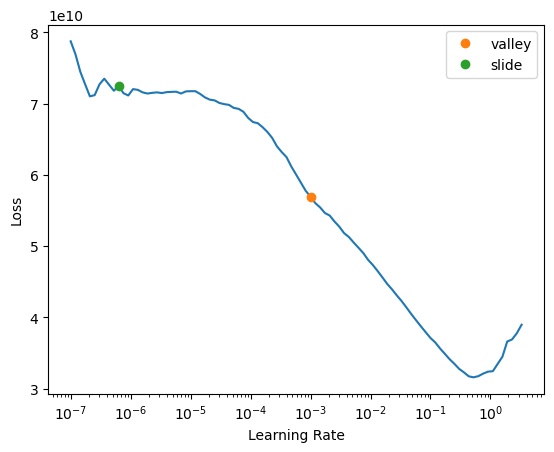

In [4]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [13]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 30983.814453125.


(#2) [981194496.0,30983.814453125]

In [16]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*15
n2 = 8*15
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 120
10 of 120
20 of 120
30 of 120
40 of 120
50 of 120
60 of 120
70 of 120
80 of 120
90 of 120
100 of 120
110 of 120
done!


In [14]:
import http.client, urllib.parse
import json

mrts = ["Chinese Garden MRT", "Jurong East MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 6162
Chinese Garden Station, Singapore, confidence 1
Jurong East Station, Singapore, confidence 1
pickle dumped. 6164


In [18]:
longLats['Upper Changi MRT']

(103.96138, 1.341393)

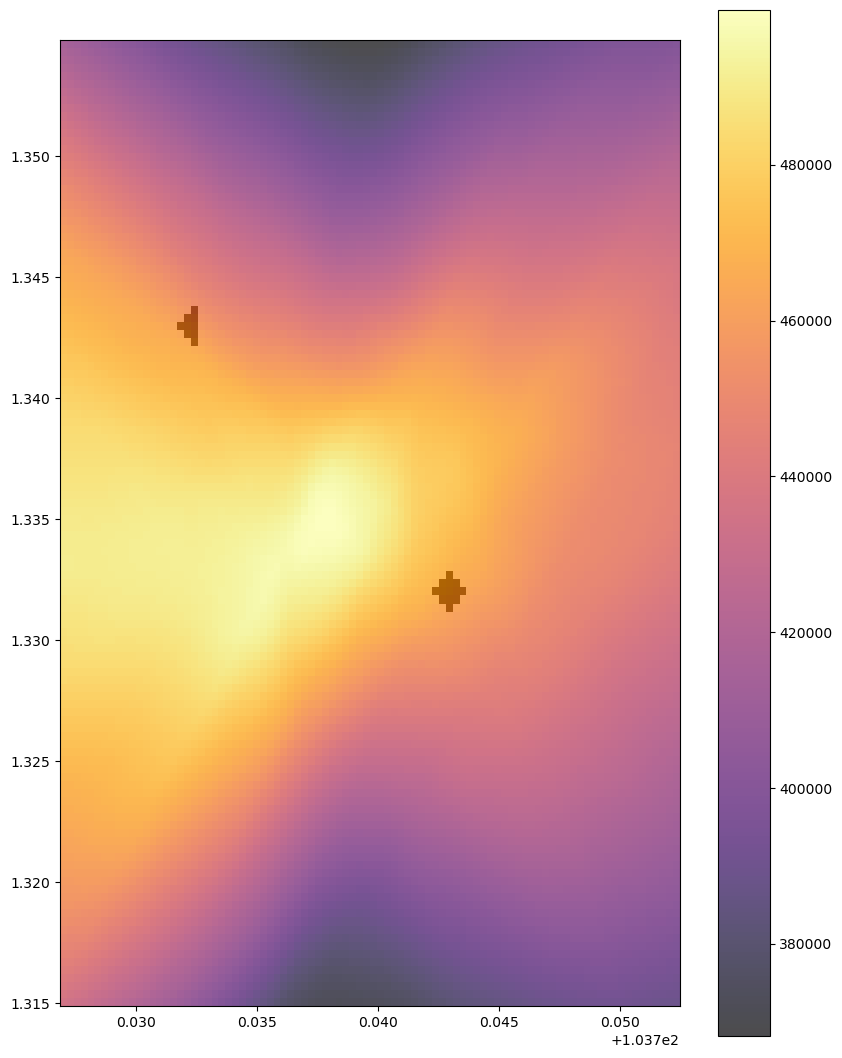

In [17]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_left(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))
#map_down(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

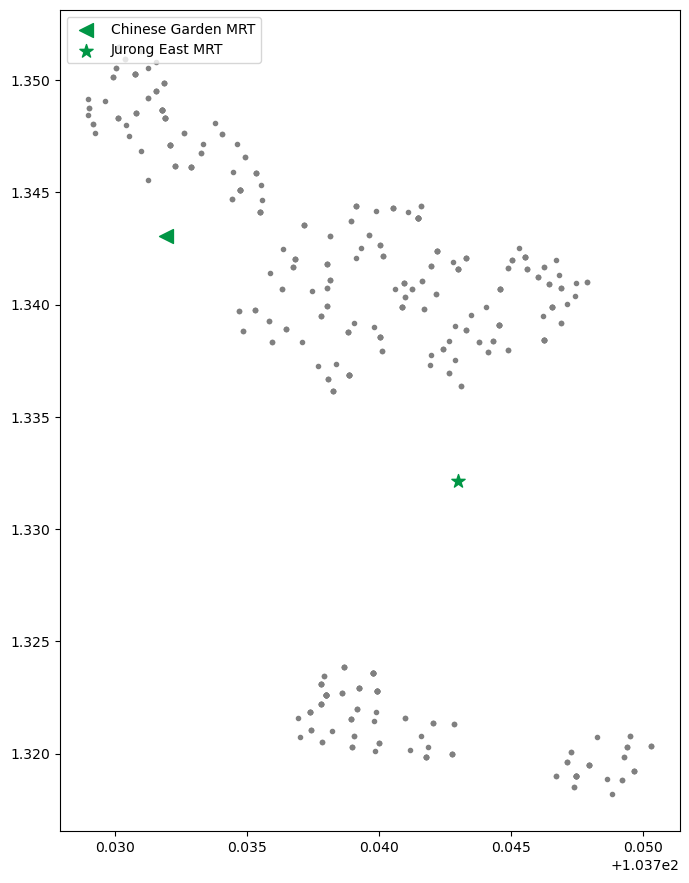

In [18]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
ne = '#9900AA'
markers = ["<", '*', "^", '>', '>', '^', '^']
colors = [ew,ew]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c="gray")
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
